# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,127875690.0,38.119,-54.480,8.96,224,800.0,805.0,1580.9,0,271,0.00000,0.0
1,127875700.0,38.118,-54.489,8.96,224,807.0,801.0,1596.0,0,271,0.00721,10.0
2,127875710.0,38.119,-54.498,8.96,224,813.0,809.0,1593.2,0,271,0.01442,20.0
3,127875720.0,38.119,-54.508,8.96,224,813.0,824.0,1573.0,0,271,0.02163,30.0
4,127875730.0,38.121,-54.515,8.96,224,820.0,825.0,1581.0,0,271,0.02884,40.0


Generate a temperature matrix

In [2]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [3]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
#x_range = (27, 37)
#y_range = (-66, -56)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_11312\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_11312\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [5]:
list_25l.shape

(25, 120, 118)

# Detect layer anomalies

In [28]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume list_25l is a NumPy array of shape (25, 120, 118)
frames = np.array(list_25l)
frames = (frames - np.mean(frames, axis=(1, 2), keepdims=True)) / np.std(frames, axis=(1, 2), keepdims=True)
J, M, N = frames.shape
p = M * N


# Step 1: Reshape each frame to 1D vector and stack them
X = frames.reshape(J, -1)  # Shape: (J, p)

# Step 2: Apply PCA
pca = PCA()
scores = pca.fit_transform(X)

# Step 3: Choose m components explaining ≥80% of variance
explained = np.cumsum(pca.explained_variance_ratio_)
m = np.searchsorted(explained, 0.60) + 1
print(m)
Z = scores[:, :m]
Lambda_inv = np.diag(1 / pca.explained_variance_[:m])

# Step 4: Compute T² for each frame (row-wise)
T2 = np.sum(Z @ Lambda_inv * Z, axis=1)  # Shape: (J,)
print(T2)

9
[18.48871679 13.3426545   4.69011715  5.16601357  4.44340626  4.86061472
  4.97030729 17.05322396  8.18284351  4.57426241 14.45944986  7.36060844
  4.90907069  3.81067477  7.94186277  5.60443513 13.37548258 17.66734905
  5.56927458 11.18122016 15.93705442  6.015115    4.08773486  5.36023684
  6.94827071]


In [ ]:
print("Variance explained by each principal component:")
print(pca.explained_variance_ratio_)
print("Cumulative variance explained by principal components:")
print(explained)

Variance explained by each principal component:
[1.63920020e-01 9.04974273e-02 8.82438426e-02 6.17702481e-02
 4.36382160e-02 4.17112984e-02 4.03253931e-02 3.82359967e-02
 3.73275953e-02 3.59065897e-02 3.43833804e-02 3.22189919e-02
 3.12437794e-02 3.03160000e-02 2.91961435e-02 2.86588518e-02
 2.69087593e-02 2.58690251e-02 2.49696282e-02 2.17626889e-02
 2.13128510e-02 2.00108521e-02 1.69634906e-02 1.46089300e-02
 3.53845846e-32]
Cumulative variance explained by principal components:
[0.16392002 0.25441745 0.34266129 0.40443154 0.44806975 0.48978105
 0.53010645 0.56834244 0.60567004 0.64157663 0.67596001 0.708179
 0.73942278 0.76973878 0.79893492 0.82759377 0.85450253 0.88037156
 0.90534119 0.92710388 0.94841673 0.96842758 0.98539107 1.
 1.        ]


(25,)

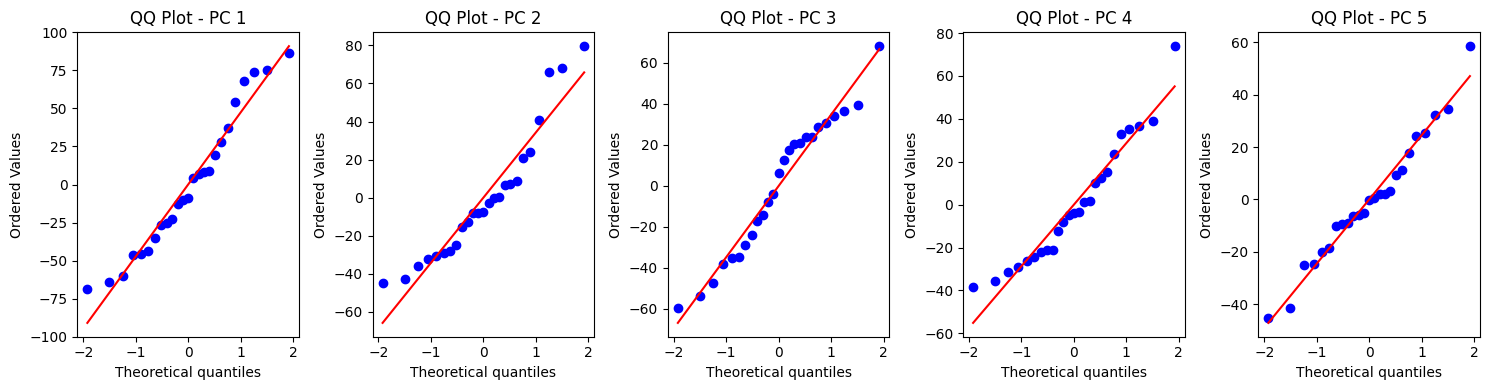

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Z contains the scores (projections) of each frame onto the first m principal components
# Assume you already have: Z = scores[:, :m]

# Choose how many PCs to inspect
num_pcs_to_check = min(5, Z.shape[1])  # Let's check the first 5 PCs (or fewer if m < 5)

fig, axs = plt.subplots(1, num_pcs_to_check, figsize=(15, 4))

for i in range(num_pcs_to_check):
    stats.probplot(Z[:, i], dist="norm", plot=axs[i])
    axs[i].set_title(f'QQ Plot - PC {i+1}')

plt.tight_layout()
plt.show()


[[-0.0065462  -0.00646217 -0.0079644  ...  0.01172806  0.01299248
   0.00840653]
 [-0.02980527 -0.03679747 -0.03638191 ...  0.01467704  0.01365886
   0.01438024]
 [ 0.01843749  0.02087371  0.0200292  ... -0.00796595 -0.00165878
  -0.00525083]
 [-0.00564065 -0.00652014 -0.00955711 ...  0.02212188  0.02736415
   0.01583622]
 [-0.00264455 -0.00142415 -0.00231806 ... -0.00618669 -0.00991832
  -0.00948803]]


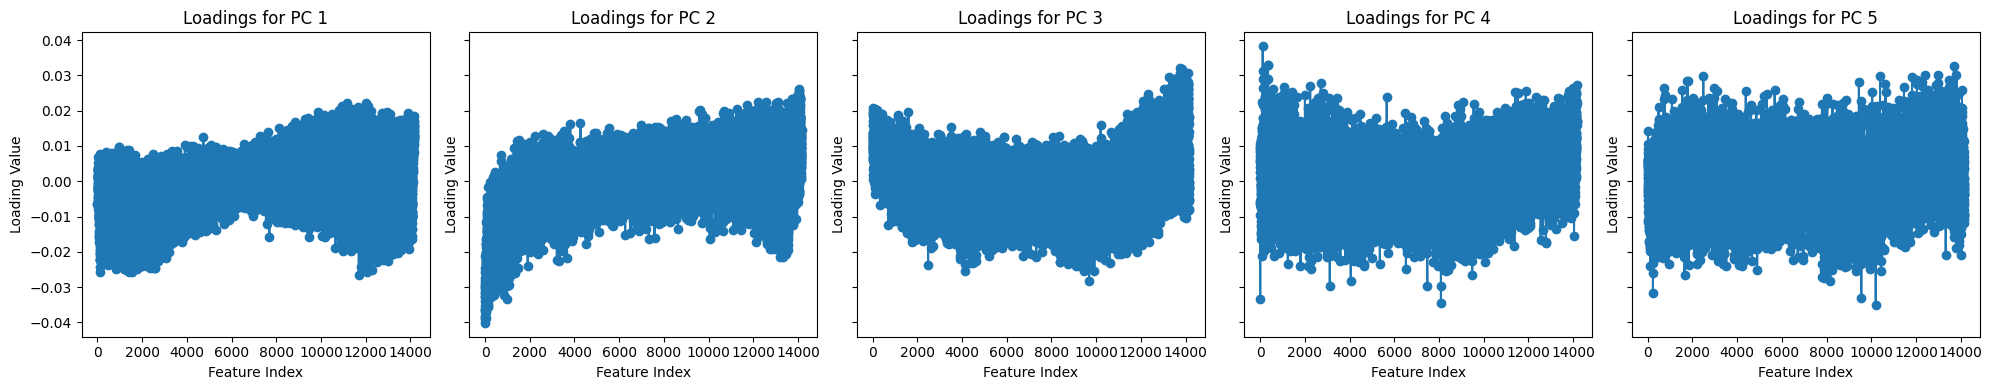

In [32]:
print(loadings)
# Plot the first 5 loadings
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i in range(5):
    axs[i].plot(loadings[i], marker='o')
    axs[i].set_title(f'Loadings for PC {i+1}')
    axs[i].set_xlabel('Feature Index')
    axs[i].set_ylabel('Loading Value')

plt.tight_layout()
plt.show()

Processing PC 1
Runs test statistic = -0.548
Runs test p-value = 0.584



c:\Users\Utente\anaconda3\envs\qda_environment\lib\site-packages\qdatoolkit\models.py:723: UserWarning: A numpy array was passed to the Assumptions class and converted to Pandas Series.
Note that all other methods in qda-toolkit only accept Pandas Series or Pandas Dataframe.
  warnings.warn(


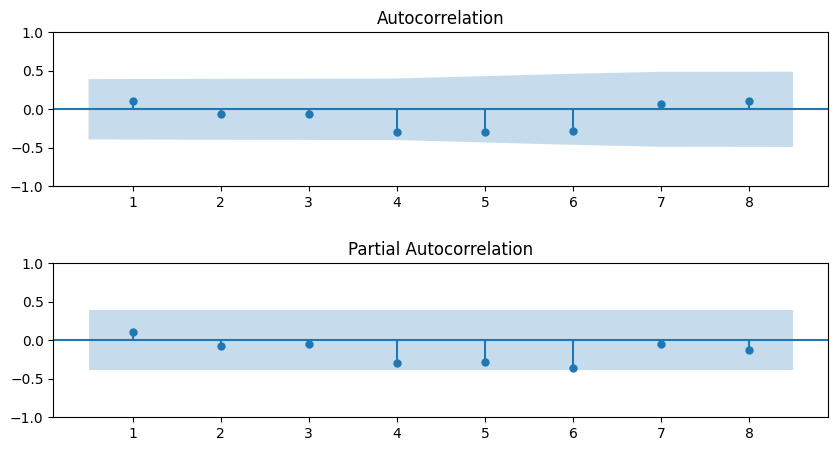

Processing PC 2
Runs test statistic = -0.548
Runs test p-value = 0.584



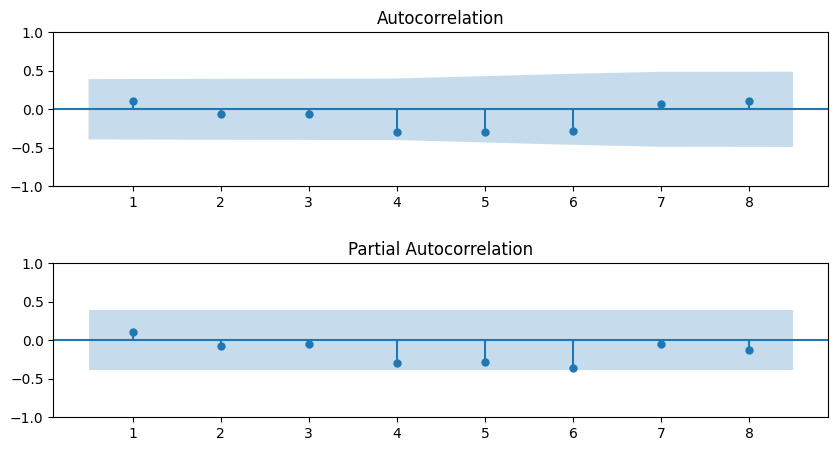

Processing PC 3
Runs test statistic = -0.548
Runs test p-value = 0.584



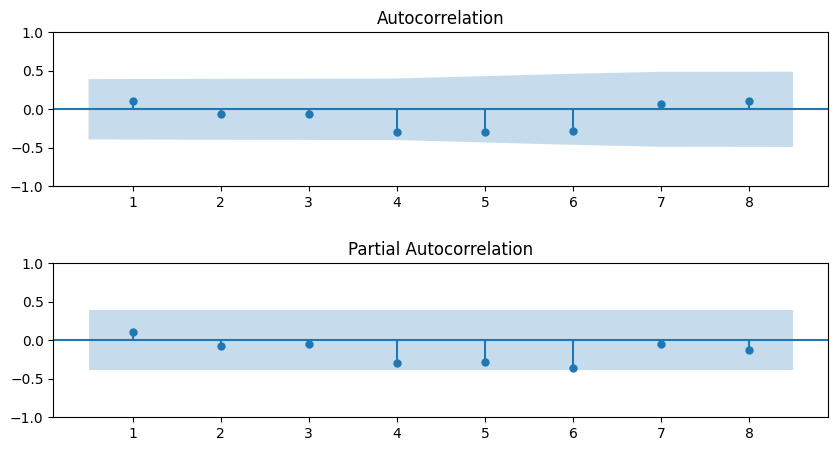

Processing PC 4
Runs test statistic = -0.548
Runs test p-value = 0.584



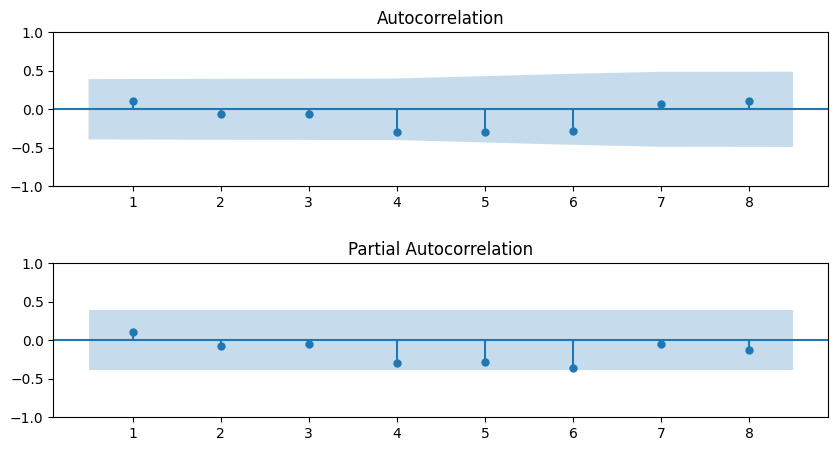

Processing PC 5
Runs test statistic = -0.548
Runs test p-value = 0.584



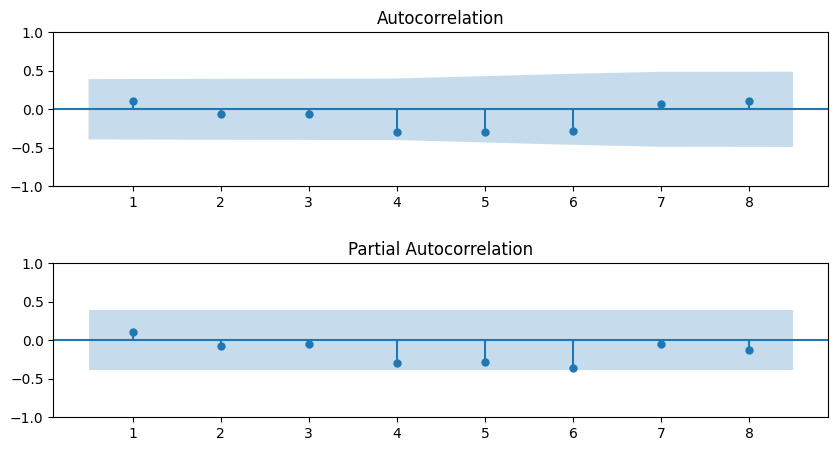

In [27]:
import qdatoolkit as qda
for i in range(5):
    print(f"Processing PC {i+1}")
    runs_statistic, runs_pvalue = qda.Assumptions(Z[:,1]).independence()

### By plotting pc1 and pc2 (come in esercitazione)

In [38]:
# Lets compute the K_alpha
alpha_fam = 0.01
alpha = 1 - (1 - alpha_fam)**(1/2)

K_alpha = stats.norm.ppf(1 - alpha/2)
print('K = {:.3f}'.format(K_alpha))

K = 2.806


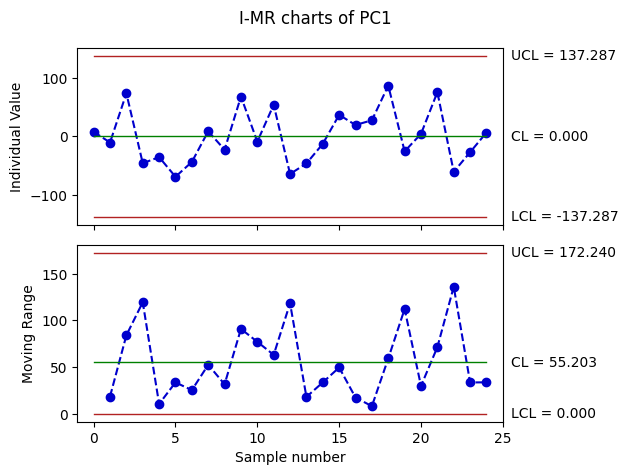

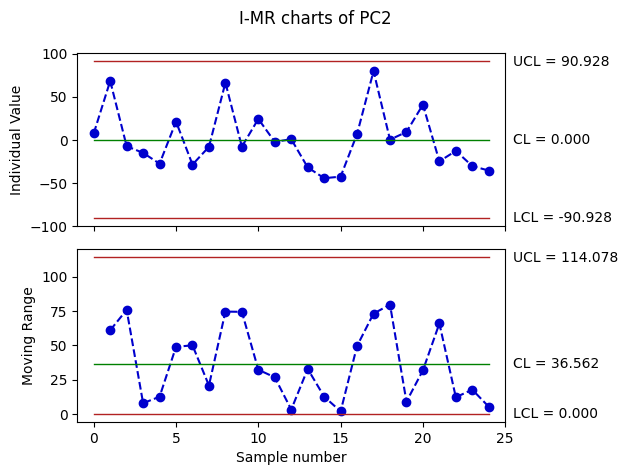

In [43]:
Z_df = pd.DataFrame(Z, columns=[f"PC{i+1}" for i in range(Z.shape[1])])
_ = qda.ControlCharts.IMR(Z_df, "PC1", K=K_alpha)
_ = qda.ControlCharts.IMR(Z_df, "PC2", K=K_alpha)

### With T2 distance

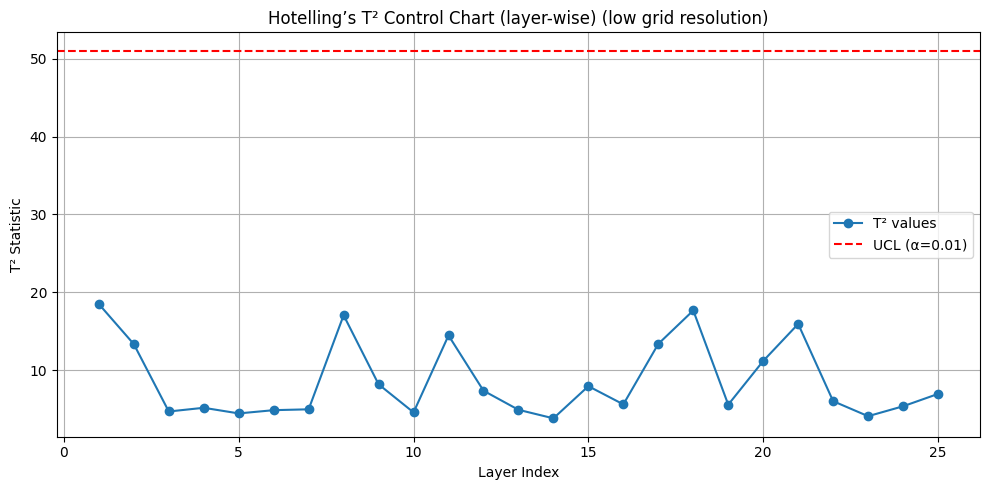

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f

# --- Assume you already have T2 from traditional unfolding PCA ---
# Shape of T2: (J,), where J = number of frames
J = len(T2)
m = Z.shape[1]  # Number of retained principal components

# --- Compute UCL using F-distribution ---
alpha = 0.01  # Significance level
UCL = (m * (J - 1) / (J - m)) * f.ppf(1 - alpha, m, J - m)

# --- Control chart ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, J + 1), T2, marker='o', label="T² values")
plt.axhline(y=UCL, color='r', linestyle='--', label=f'UCL (α={alpha})')
plt.title("Hotelling’s T² Control Chart (layer-wise) (low grid resolution)")
plt.xlabel("Layer Index")
plt.ylabel("T² Statistic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# --- Assume you already have T2 from traditional unfolding PCA ---
# Shape of T2: (J,), where J = number of frames
J = len(T2)

# --- Parameters for CUMSUM ---
target = np.mean(T2)  # Target value (mean of T²)
k = 0.5 * np.std(T2)  # Reference value (half the standard deviation of T²)
h = 5 * np.std(T2)    # Decision interval (5 times the standard deviation of T²)

# --- Compute CUMSUM statistics ---
S_pos = np.zeros(J)  # Positive CUMSUM
S_neg = np.zeros(J)  # Negative CUMSUM

for i in range(1, J):
    S_pos[i] = max(0, S_pos[i-1] + (T2[i] - target - k))
    S_neg[i] = max(0, S_neg[i-1] + (target - T2[i] - k))

# --- Plot CUMSUM control chart ---
plt.figure(figsize=(12, 6))
plt.plot(range(1, J + 1), S_pos, label="CUMSUM Positive", color='blue')
plt.plot(range(1, J + 1), S_neg, label="CUMSUM Negative", color='orange')
plt.axhline(y=h, color='red', linestyle='--', label=f'Decision Interval (h={h:.2f})')
plt.title("CUMSUM Control Chart for T² Statistic")
plt.xlabel("Layer Index")
plt.ylabel("CUMSUM Statistic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

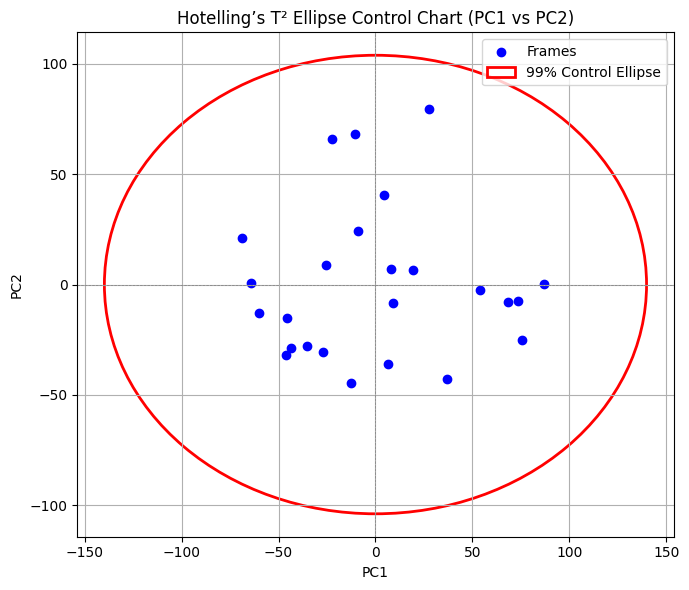

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# Assume you already have:
# Z = scores[:, :2]  # First two principal components (shape: J × 2)
Z2 = Z[:, :2]  # Get first two PCs
J = Z2.shape[0]

# Compute mean and covariance of the 2D scores
mu = np.mean(Z2, axis=0)
cov = np.cov(Z2.T)

# Get the Mahalanobis distance threshold from Chi-squared dist with 2 df
alpha = 0.01  # 99% confidence ellipse
threshold = chi2.ppf(1 - alpha, df=2)

# Eigen-decomposition for ellipse axes
eigvals, eigvecs = np.linalg.eigh(cov)
order = eigvals.argsort()[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[:, order]

# Width and height of ellipse (2*sqrt for full width)
width, height = 2 * np.sqrt(threshold * eigvals)
angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))

# Plot
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(Z2[:, 0], Z2[:, 1], c='blue', label='Frames')
ellipse = Ellipse(xy=mu, width=width, height=height, angle=angle,
                  edgecolor='red', fc='None', lw=2, label='99% Control Ellipse')
ax.add_patch(ellipse)

ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Hotelling’s T² Ellipse Control Chart (PC1 vs PC2)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Benchmark analysis

Compare what we have done with a simple approach of taking the average temperature of the layer.

In [63]:
# Remove outliers using the IQR method
Q1 = df.groupby('layer_id')['temp'].quantile(0.25)
Q3 = df.groupby('layer_id')['temp'].quantile(0.75)
IQR = Q3 - Q1

# Filter out rows where 'temp' is outside 1.5*IQR range
df_filtered = df[~((df['temp'] < (Q1.loc[df['layer_id']].values - 1.5 * IQR.loc[df['layer_id']].values)) | 
                  (df['temp'] > (Q3.loc[df['layer_id']].values + 1.5 * IQR.loc[df['layer_id']].values)))]

average_temp_by_layer = df_filtered.groupby('layer_id')['temp'].mean()
print(average_temp_by_layer)

layer_id
224    1563.300651
225    1562.460317
226    1559.696374
227    1546.099312
228    1546.902505
324    1548.329838
325    1546.126857
326    1560.087712
327    1561.029390
328    1559.912232
424    1559.333656
425    1557.848557
426    1539.755721
427    1539.002516
428    1552.921944
524    1562.111191
525    1561.924910
526    1564.870017
527    1558.555772
528    1541.306634
569    1561.172226
570    1560.992887
571    1544.873048
572    1544.631318
573    1554.440113
Name: temp, dtype: float64


Runs test statistic = -1.706
Runs test p-value = 0.088



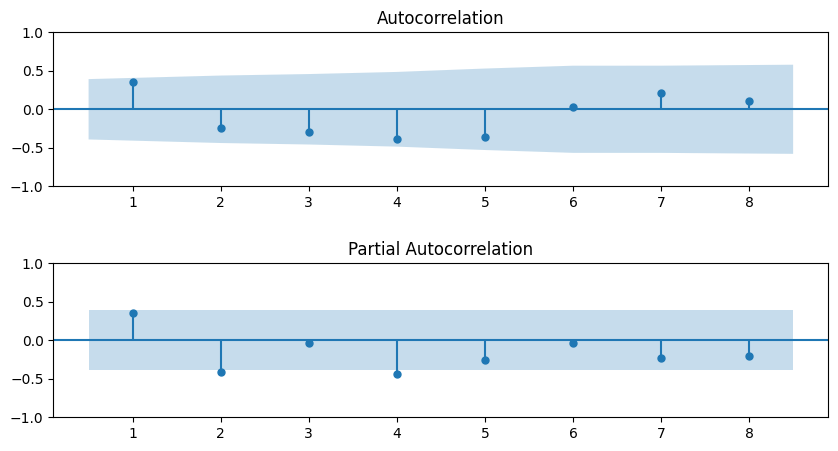

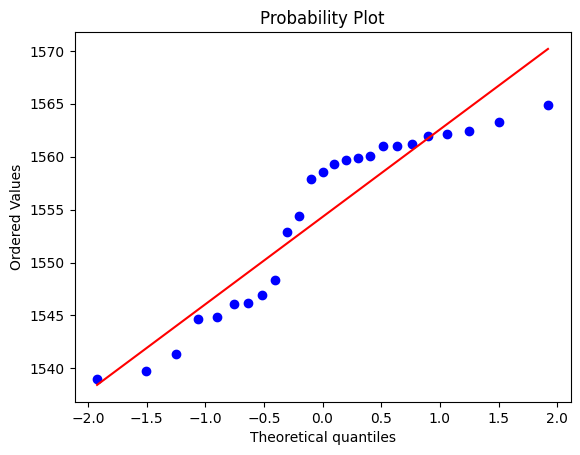

Shapiro-wilk test statistic = 0.871
Shapiro-wilk test p-value = 0.005


In [64]:
import qdatoolkit as qda
independence_statistic, independence_pvalue = qda.Assumptions(average_temp_by_layer).independence()
normality_statistic, normality_pvalue = qda.Assumptions(average_temp_by_layer).normality()

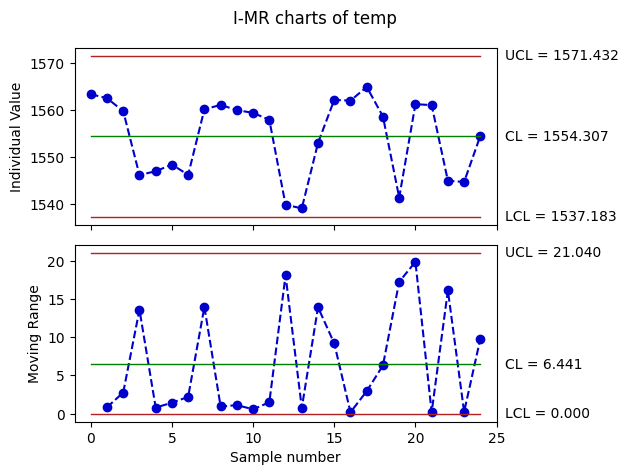

In [65]:
# Convert the Series to a DataFrame
average_temp_df = average_temp_by_layer.reset_index()
average_temp_df.columns = ['layer_id', 'temp']  # Rename columns to match expected input

# Use the DataFrame in the IMR control chart
_ = qda.ControlCharts.IMR(average_temp_df, "temp", K=3)

# References
* [In-Process Monitoring of Selective Laser Melting: Spatial Detection of Defects Via Image Data Analysis](https://re.public.polimi.it/bitstream/11311/1016879/6/in-process%20monitoring%20of%20slm.pdf)
* Montgomery D. C. 2008. “Introduction to Statistical Quality Control”, John Wiley 
& Sons, 6th Ed 

# Further improvements